In [1]:
# Importing necessities for the analysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib



In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("max_colwidth", None)

In [3]:
# Loading the data
df_churn=pd.read_csv('data/Churn_prepared.csv',index_col='customerID')

In [4]:

rf_model = joblib.load('random_forest_model.pkl')
logreg_model = joblib.load('logistic_regression_model.pkl')
svm_model = joblib.load('svc_model.pkl')
xgb_model = joblib.load('xgb_model.pkl')
mlp_model = joblib.load('mlp_model.pkl')
gnb_model = joblib.load('naive_bayes_model.pkl')
models=[rf_model,logreg_model,svm_model,xgb_model,mlp_model,gnb_model]
model_names = ['Random Forest','Logistic Regression', 'SVC', 'XGBoost', 'MLP', 'Naive Bayes']


In [5]:

X = df_churn.drop(columns=['Churn'])
y = df_churn['Churn']

# Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# Scale features for models that need scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:

# Evaluation metrics
results = pd.DataFrame(columns=['Model', 'Mean Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1 Score', 'Mean ROC AUC', 
                                'Best Threshold', 'Accuracy After Threshold', 'Precision After Threshold', 'Recall After Threshold', 
                                'F1 Score After Threshold', 'ROC AUC After Threshold'])

# Thresholds to loop over
thresholds_range = np.arange(0.0, 1.01, 0.01) 

# Evaluate each model
for model, name in zip(models, model_names):
    if name in ['Logistic Regression', 'SVC', 'MLP']:
        X_data = X_train_scaled
    else:
        X_data = X_train

    # Cross-validate model
    cv_accuracy = cross_val_score(model, X_data, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_precision = cross_val_score(model, X_data, y_train, cv=5, scoring='precision', n_jobs=-1)
    cv_recall = cross_val_score(model, X_data, y_train, cv=5, scoring='recall', n_jobs=-1)
    cv_f1 = cross_val_score(model, X_data, y_train, cv=5, scoring='f1', n_jobs=-1)
    cv_roc_auc = cross_val_score(model, X_data, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

    # Fit the model on the full training data to get probabilities
    model.fit(X_data, y_train)
    y_probs = model.predict_proba(X_data)[:, 1]  

    # Metrics for manual thresholding
    best_f1_score = -1
    best_threshold = None

    # Loop through the thresholds to find the best one
    for threshold in thresholds_range:
        # Apply the threshold to get binary predictions
        y_pred_thresholded = (y_probs >= threshold).astype(int)

        # Calculate metrics after applying the threshold
        precision_after_threshold = precision_score(y_train, y_pred_thresholded)
        recall_after_threshold = recall_score(y_train, y_pred_thresholded)
        f1_after_threshold = f1_score(y_train, y_pred_thresholded)

        # Keep track of the threshold with the best F1 score
        if f1_after_threshold > best_f1_score:
            best_f1_score = f1_after_threshold
            best_threshold = threshold
            best_precision_after_threshold = precision_after_threshold
            best_recall_after_threshold = recall_after_threshold
            best_accuracy_after_threshold = accuracy_score(y_train, y_pred_thresholded)

    # Calculate ROC AUC on the probabilities, not affected by threshold
    roc_auc_after_threshold = roc_auc_score(y_train, y_probs)

    # Store mean metrics from cross-validation and the best thresholding metrics
    new_result = pd.DataFrame({
        'Model': [name],
        'Mean Accuracy': [cv_accuracy.mean()],
        'Mean Precision': [cv_precision.mean()],
        'Mean Recall': [cv_recall.mean()],
        'Mean F1 Score': [cv_f1.mean()],
        'Mean ROC AUC': [cv_roc_auc.mean()],
        'Best Threshold': [best_threshold],
        'Accuracy After Threshold': [best_accuracy_after_threshold],
        'Precision After Threshold': [best_precision_after_threshold],
        'Recall After Threshold': [best_recall_after_threshold],
        'F1 Score After Threshold': [best_f1_score],
        'ROC AUC After Threshold': [roc_auc_after_threshold]
    })

    # Concatenate the result
    results = pd.concat([results, new_result], ignore_index=True)



c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [7]:
results = results.sort_values(by='Mean ROC AUC', ascending=False)
results

,Model,Mean Accuracy,Mean Precision,Mean Recall,Mean F1 Score,Mean ROC AUC,Best Threshold,Accuracy After Threshold,Precision After Threshold,Recall After Threshold,F1 Score After Threshold,ROC AUC After Threshold
3,XGBoost,0.805645,0.672895,0.519088,0.585412,0.846912,0.33,0.790912,0.581299,0.750503,0.655152,0.866038
0,Random Forest,0.803161,0.679923,0.485558,0.565961,0.844536,0.34,0.798545,0.592516,0.764588,0.667643,0.875821
1,Logistic Regression,0.802626,0.651819,0.547272,0.594601,0.843285,0.30,0.764821,0.538785,0.773307,0.635087,0.847410
4,MLP,0.800142,0.651767,0.530500,0.584268,0.839333,0.28,0.762691,0.534936,0.790744,0.638160,0.854594
2,SVC,0.798722,0.666294,0.482874,0.559292,0.831725,0.29,0.769436,0.548096,0.733736,0.627473,0.833048
5,Naive Bayes,0.740858,0.506780,0.782692,0.615029,0.830503,0.83,0.781860,0.571978,0.698189,0.628813,0.831925


- Mean Accuracy: Shows how often the model predicts correctly. NOTE accuracy can be misleading if the data is imbalanced and this is the case for our and most of the churn datasets.
- Mean Precision: The proportion of true churn predictions out of all churn predictions made. High precision means fewer false positives.
- Mean Recall: Measures how well the model identifies actual churn cases. High recall means fewer false negatives.
This metric can be very important from a business perspective, high FN can generate a lot of cost for the company as they are missing the opportunity to reach out and try to retain the customers.
- Mean F1 Score: Balance between precision and recall.
- ROC AUC: The ability of the model to distinguish between churn and non-churn. Higher ROC AUC is better, as it shows a better trade-off between true positive and false positive rates.
This is imortant, because we want to minimize False negatives(missed churners), but also want to keep False positives low to avoid a high nuber of 'false alarms' as it can generate unnecessary cost for the company.
Worth to mention here that to find the right balance we need to now how high is the average cost of a churn and the cost of retaining customers.
- Post-Threshold Metrics: After applying the "Best Threshold," these metrics show how well the model performs when adjusted for class imbalance or business requirements.

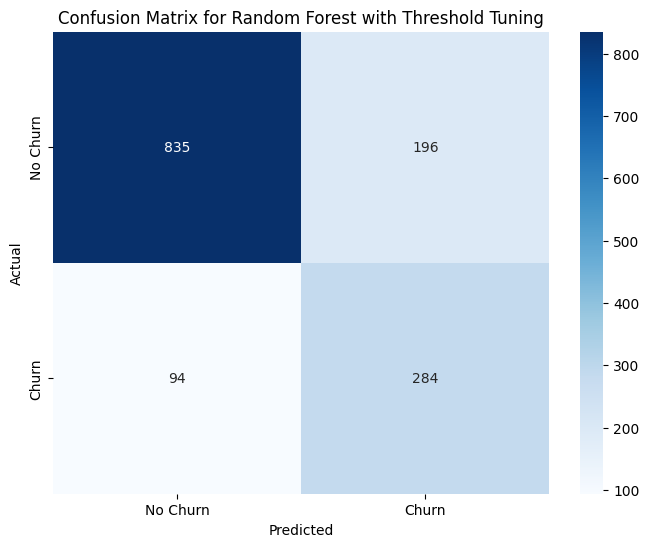

Classification Report for Random Forest with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1031
           1       0.59      0.75      0.66       378

    accuracy                           0.79      1409
   macro avg       0.75      0.78      0.76      1409
weighted avg       0.82      0.79      0.80      1409



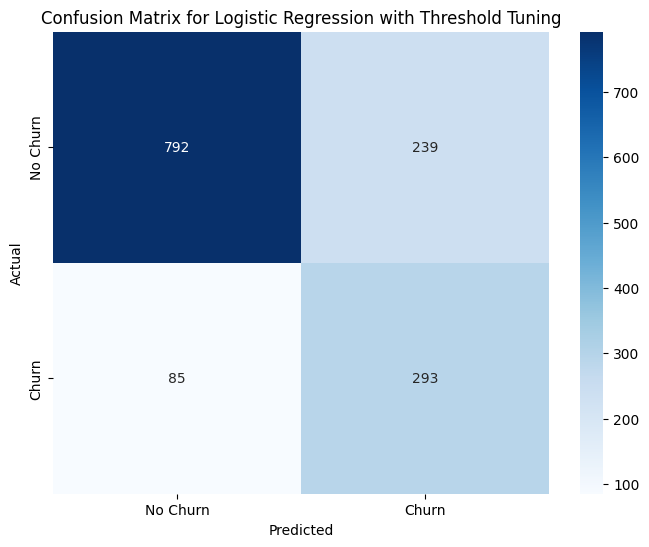

Classification Report for Logistic Regression with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1031
           1       0.55      0.78      0.64       378

    accuracy                           0.77      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.77      0.78      1409



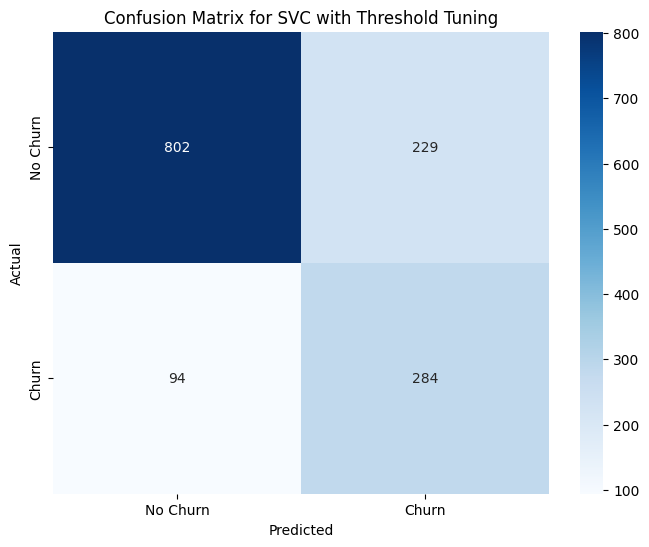

Classification Report for SVC with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.90      0.78      0.83      1031
           1       0.55      0.75      0.64       378

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409



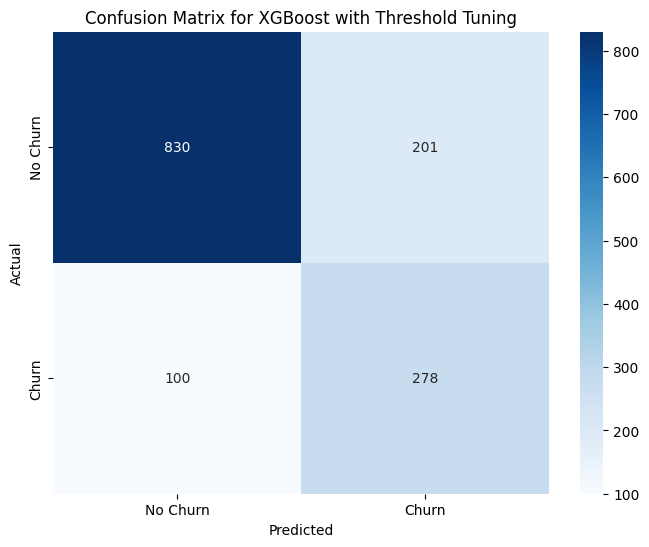

Classification Report for XGBoost with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1031
           1       0.58      0.74      0.65       378

    accuracy                           0.79      1409
   macro avg       0.74      0.77      0.75      1409
weighted avg       0.81      0.79      0.79      1409



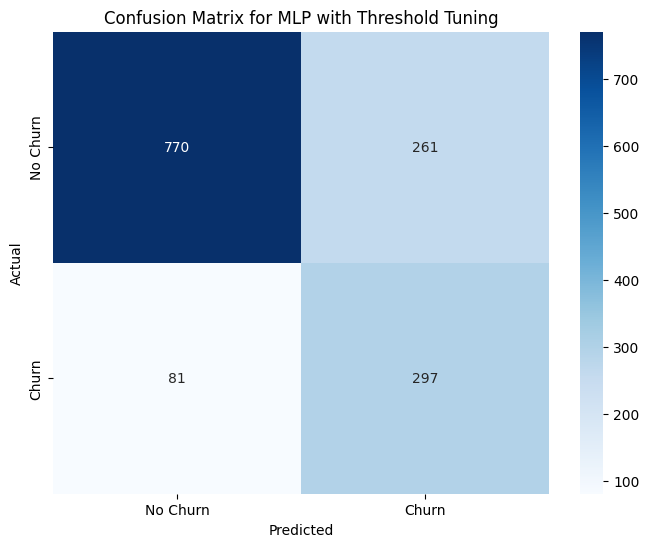

Classification Report for MLP with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1031
           1       0.53      0.79      0.63       378

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.80      0.76      0.77      1409



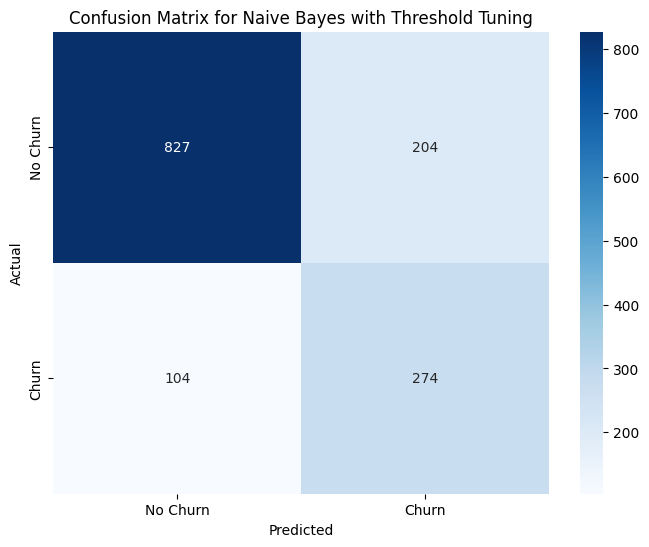

Classification Report for Naive Bayes with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1031
           1       0.57      0.72      0.64       378

    accuracy                           0.78      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.78      0.79      1409



In [8]:
# predictions with the best threshold
for model, name in zip(models, model_names):
    if name in ['Logistic Regression', 'SVC', 'MLP']:
        model.fit(X_train_scaled, y_train)
        y_probs = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_probs = model.predict_proba(X_test)[:, 1]

    # Apply the best threshold
    y_pred_adjusted = (y_probs >= results.loc[results['Model'] == name, 'Best Threshold'].values[0]).astype(int)

    # Confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {name} with Threshold Tuning')
    plt.show()

    class_report = classification_report(y_test, y_pred_adjusted)
    print(f'Classification Report for {name} with Threshold Tuning:\n')
    print(class_report)


# Comparison of Model Performances
## 1. Random Forest:

   - Precision (0): 0.90
   - Precision (1): 0.59
   - Recall (0): 0.81
   - Recall (1): 0.75
   - F1-Score (0): 0.85
   - F1-Score (1): 0.66
   - Accuracy: 0.79

### Strengths:

    High overall precision for non-churners (class 0) and a good balance between precision and recall for churners (class 1).
    Strong recall for churners (0.75), effectively capturing a significant number of churn cases.

## 2. Logistic Regression:

   - Precision (0): 0.90
   - Precision (1): 0.55
   - Recall (0): 0.77
   - Recall (1): 0.78
   - F1-Score (0): 0.83
   - F1-Score (1): 0.64
   - Accuracy: 0.77

### Strengths:

    Performance similar to Random Forest, but with slightly lower recall for non-churners.
    Good recall for churners (0.78), although the lower precision for churners (0.55) indicates a higher risk of false positives.

## 3. SVC:

   - Precision (0): 0.90
   - Precision (1): 0.55
   - Recall (0): 0.78
   - Recall (1): 0.75
   - F1-Score (0): 0.83
   - F1-Score (1): 0.64
   - Accuracy: 0.77

### Strengths:

    Comparable performance to Logistic Regression and Random Forest, with slightly lower recall for non-churners (0.78).
    Balanced F1-scores for both classes, providing a solid overall performance.

## 4. XGBoost:

   - Precision (0): 0.89
   - Precision (1): 0.58
   - Recall (0): 0.81
   - Recall (1): 0.74
   - F1-Score (0): 0.85
   - F1-Score (1): 0.65
   - Accuracy: 0.79

### Strengths:

    Similar to Random Forest in most metrics, with good precision for churners (0.58).
    Strong F1-score for non-churners (0.85), indicating effective performance.

## 5. MLP:

   - Precision (0): 0.90
   - Precision (1): 0.53
   - Recall (0): 0.75
   - Recall (1): 0.79
   - F1-Score (0): 0.82
   - F1-Score (1): 0.63
   - Accuracy: 0.76

### Strengths:

    Highest accuracy (0.76) and strong F1-score for non-churners (0.82), though lower precision for churners (0.53) compared to other models.
    The relatively lower recall for churners (0.79) suggests a moderate risk of missing churn cases.

## 6. Naive Bayes:

   - Precision (0): 0.89
   - Precision (1): 0.57
   - Recall (0): 0.80
   - Recall (1): 0.72
   - F1-Score (0): 0.84
   - F1-Score (1): 0.64
   - Accuracy: 0.78

### Strengths:

    Similar performance to MLP, with decent recall for churners but a lower precision (0.57) which indicates some difficulty distinguishing churners from non-churners.

## Summary of Best Models for Churn Prediction:

    XGBoost and Random Forest consistently perform well, demonstrating high precision, recall, and F1-scores for both churn and non-churn classes.
    MLP has the highest overall accuracy and strong F1 for non-churners, but slightly lower recall for churners.
    Naive Bayes and SVC are less effective in capturing churn cases due to lower recall.

### Model Choice:

    XGBoost or Random Forest would be the optimal choices based on their robust balance of precision, recall, and F1-score across both churn and non-churn classes. These models effectively minimize false negatives (mislabeling true churners) while controlling false positives (false alarms).